In [14]:
import numpy as np
import nltk
from nltk.corpus import brown
import gensim
import re
import string
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits import mplot3d
import sklearn
from sklearn.cluster import KMeans, DBSCAN

In [3]:
# nltk.download('brown')
brown.categories()

['adventure',
 'belles_lettres',
 'editorial',
 'fiction',
 'government',
 'hobbies',
 'humor',
 'learned',
 'lore',
 'mystery',
 'news',
 'religion',
 'reviews',
 'romance',
 'science_fiction']

In [4]:
sentences = brown.sents(categories = brown.categories())
sentences = [[token.lower() for token in sent if not re.search("[{}\d]".format(string.punctuation), token)] for sent in sentences]

In [40]:
word2vec = gensim.models.Word2Vec(sentences, size = 3, iter = 700, min_count = 50, window = 15)
word2vec.save("word2vec.model")

In [6]:
index2word = np.array(word2vec.wv.index2word)

In [7]:
len(index2word)

2168

In [26]:
kmeans = KMeans(n_clusters = 11).fit(word2vec.wv.vectors)
clusters = [np.array([i for i, cluster in enumerate(kmeans.labels_) if cluster == j]) for j in range(min(kmeans.labels_), max(kmeans.labels_) + 1)]

In [37]:
dbscan = DBSCAN(eps = 0.6).fit(word2vec.wv.vectors)
clusters = [np.array([i for i, cluster in enumerate(dbscan.labels_) if cluster == j]) for j in range(min(dbscan.labels_), max(dbscan.labels_) + 1)]

In [38]:
len(clusters)

20

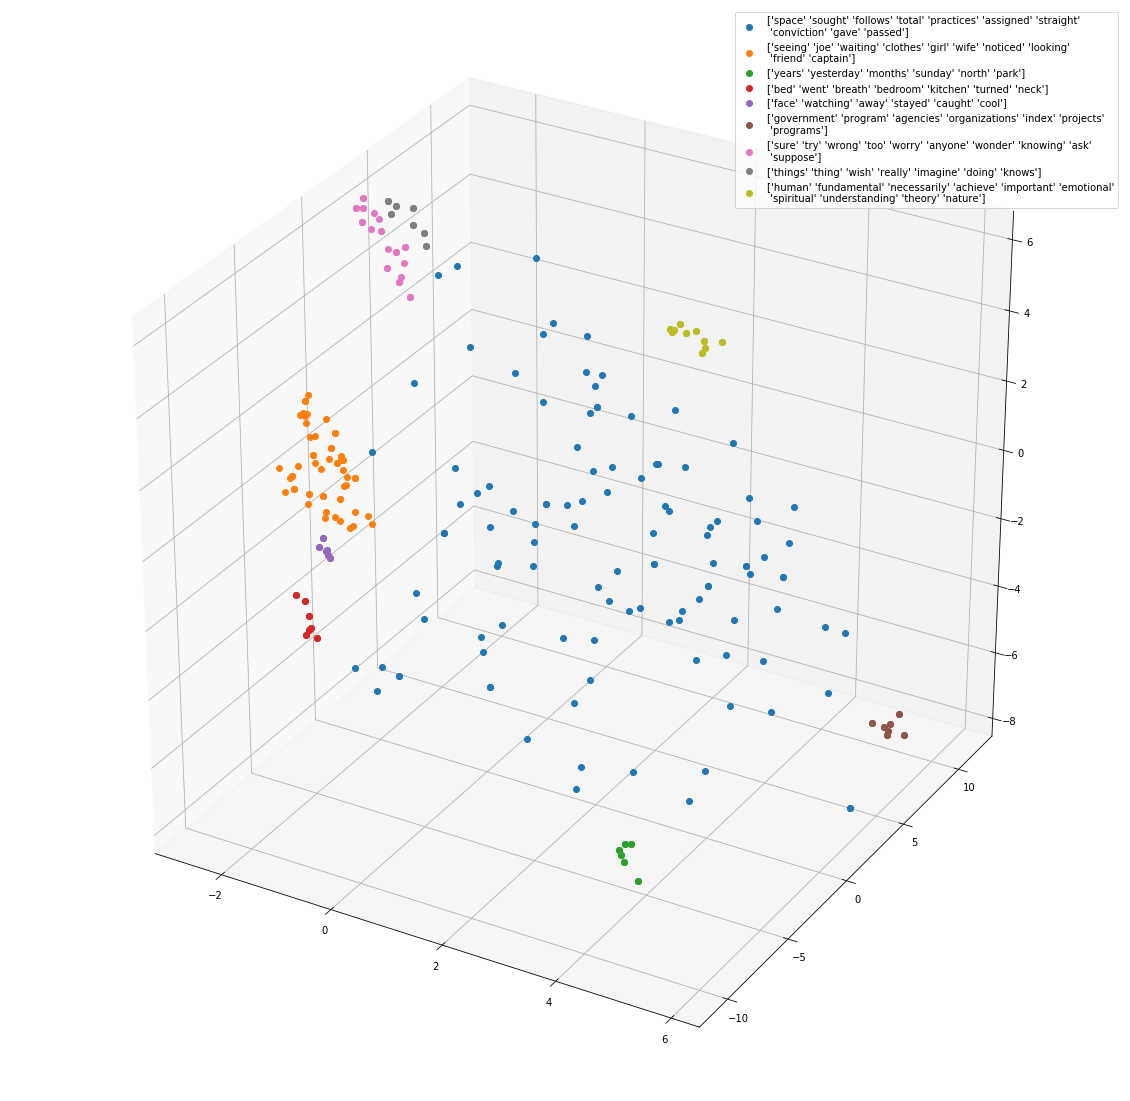

In [39]:
num_per_cluster = 100
num_labeled_per_cluster = 10

plt.figure(figsize = (20, 20))
ax = plt.axes(projection='3d')

# go through all clusters
for i, cluster in enumerate(clusters[1:10]):
    # select color
    color = list(mcolors.TABLEAU_COLORS.items())[i][0]
    # choose random words to display
    random_instances = np.random.choice(cluster, min(len(cluster), num_per_cluster), replace = False)
    # choose random words to label in the plot
    random_label_instances = np.random.choice(random_instances, min(len(random_instances), num_labeled_per_cluster), replace = False)
    
    # plot some embeddings with a label
    x, y, z = zip(*word2vec.wv.vectors[random_label_instances])
    ax.plot3D(x, y, z, "o", color = color, label = index2word[random_label_instances])
    # plot the remaining embeddings without a label
    x, y, z = zip(*word2vec.wv.vectors[random_instances])
    ax.plot3D(x, y, z, "o", color = color)

plt.legend()
plt.show()